<a href="https://colab.research.google.com/github/Alen0101/PreddiplomnayaPraktika/blob/main/PreddiplomnayaPraktika.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Преддипломная практика Фамилия Имя отчество на тему «Разработка интеллектуальной системы определения эмоциональной окраски сообщений в Центре поддержки» на основе датасета https://huggingface.co/datasets/MonoHime/ru_sentiment_dataset

In [3]:
# Установка
!pip install -q transformers datasets accelerate peft bitsandbytes==0.39.0 evaluate wandb sqlalchemy "psycopg[binary]" uvicorn fastapi faststream python-dotenv scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 135.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.4/503.4 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.8/206.8 kB 21.8 MB/s eta 0:00:00


In [4]:
# Импортируем необходимыеы библиотеки
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import Counter

# Hugging Face / Transformers / Datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset

# sklearn utilities
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report


In [5]:
# GPU, загрузка датасета
# Проверяем устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используем устройство:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

# Загружаем датасет (публичный)
print("\nЗагрузка датасета...")
ds = load_dataset("MonoHime/ru_sentiment_dataset")

# Краткая информация
print("\nСтруктура датасета:", ds)
print("Кол-во train:", len(ds['train']), " validation:", len(ds['validation']))
print("Столбцы:", ds['train'].column_names)

# Покажем первые 3 примера (коротко)
print("\nПервые 3 примера (сокращённо):")
for i in range(3):
    text = ds['train'][i]['text']
    label = ds['train'][i]['sentiment']
    print(f"{i}: label={label} | text (начало): {text[:200].replace('\\n',' ')}")


Используем устройство: cuda
GPU: Tesla T4

Загрузка датасета...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.csv:   0%|          | 0.00/276M [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/32.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/189891 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21098 [00:00<?, ? examples/s]


Структура датасета: DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'sentiment'],
        num_rows: 189891
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'text', 'sentiment'],
        num_rows: 21098
    })
})
Кол-во train: 189891  validation: 21098
Столбцы: ['Unnamed: 0', 'text', 'sentiment']

Первые 3 примера (сокращённо):
0: label=1 | text (начало): .с.,и спросил его:  о Посланник Аллаха!Ты порицаешь что-то из слушания?  Он ответил: я не порицаю ничего из него,но передай им,чтобы они открывали свои собрания Кораном и закрывали их Кораном ........
1: label=1 | text (начало): Роднее всех родных Попала я в ГКБ №8 еще в декабре 2002 г. Ехать в больницу очень боялась, но делать нечего, рожать надо. О ГКБ № 8 слышала много хорошего. Когда приехала в приемное отделение, мои кол
2: label=2 | text (начало): Непорядочное отношение к своим работникам Работаю в сети Доктор Столетов Центр. В моем трудовом договоре прописано, что работад. оплачивает

In [6]:
# Удаляем индексную колонку и проверяем метки/распределение
# Если столбец 'Unnamed: 0' есть — удаляем
if 'Unnamed: 0' in ds['train'].column_names:
    ds = ds.remove_columns(['Unnamed: 0'])
    print("Удалена колонка 'Unnamed: 0'")

# Проверяем уникальные метки и распределение
unique_train = set(ds['train']['sentiment'])
unique_val = set(ds['validation']['sentiment'])
print("Уникальные метки (train):", unique_train)
print("Уникальные метки (validation):", unique_val)

# Распределение
train_counts = Counter(ds['train']['sentiment'])
val_counts = Counter(ds['validation']['sentiment'])
print("\nРаспределение классов:")
print("Train:", train_counts)
print("Validation:", val_counts)


Удалена колонка 'Unnamed: 0'
Уникальные метки (train): {0, 1, 2}
Уникальные метки (validation): {0, 1, 2}

Распределение классов:
Train: Counter({1: 90766, 2: 49798, 0: 49327})
Validation: Counter({1: 10026, 0: 5560, 2: 5512})


In [8]:
# Токенизатор + анализ длин текстов для выбора max_length
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

# Вычисляем длины (в токенах) первых N примеров эффективно батчами
texts = ds['train']['text']  # это list-like
text_lengths = [len(tokenizer.tokenize(t)) for t in texts]

# Перцентиль
p95 = int(np.percentile(text_lengths, 95))
p99 = int(np.percentile(text_lengths, 99))
print("95-й перцентиль (tokens):", p95)
print("99-й перцентиль (tokens):", p99)

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

95-й перцентиль (tokens): 474
99-й перцентиль (tokens): 1037


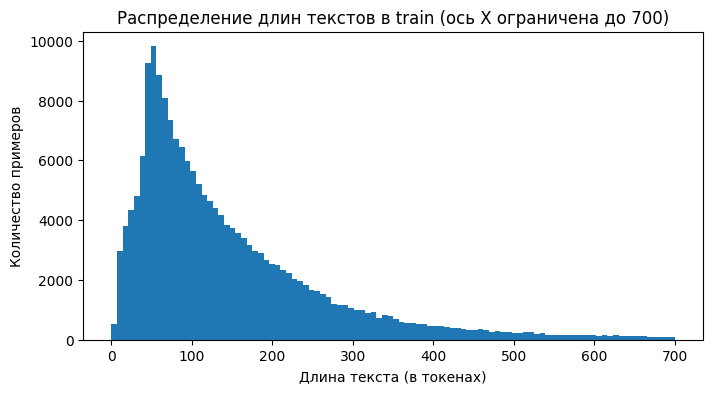

In [9]:
# Визуализация (ограничим ось X до 700 чтобы график был читаем)
plt.figure(figsize=(8,4))
plt.hist(text_lengths, bins=100, range=(0,700))  # ограничиваем до 700 токенов
plt.xlabel("Длина текста (в токенах)")
plt.ylabel("Количество примеров")
plt.title("Распределение длин текстов в train (ось X ограничена до 700)")
plt.show()

In [10]:
# Округлим max_length до 512 для совместимости и эффективности
max_length = 512